In [2]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   --------------------------------------  614.4/614.7 kB 19.5 MB/s eta 0:00:01
   --------------------------------------- 614.7/614.7 kB 13.1 MB/s eta 0:00:00


In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

import pmdarima as pm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot

warnings.filterwarnings('ignore')

In [160]:
deaths_df=pd.read_csv('time_series_covid19_deaths_global.csv')
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/22,5/7/22,5/8/22,5/9/22,5/10/22,5/11/22,5/12/22,5/13/22,5/14/22,5/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7684,7684,7684,7685,7685,7686,7686,7686,7687,7690
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3496,3496,3497,3497,3497,3497,3497,3497,3497,3497
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6875,6875,6875,6875,6875,6875,6875,6875,6875,6875
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,153,153,153,153,153,153,153,153,153,153
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


In [161]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/6/22', '5/7/22', '5/8/22', '5/9/22', '5/10/22', '5/11/22', '5/12/22',
       '5/13/22', '5/14/22', '5/15/22'],
      dtype='object', length=849)

In [162]:
 d=deaths_df.loc[:, '1/22/20':]
    
    
#transpose the dataframe
d=d.transpose() 

### sum row-wise
d=d.sum(axis=1)

# convert d to a list since we only need the numeric values
d.head()
    

1/22/20    17
1/23/20    18
1/24/20    26
1/25/20    42
1/26/20    56
dtype: int64

In [163]:
d=d.to_list()

# create a new data frame with two columns. 
dataset=pd.DataFrame(columns=['ds','y'])

# get the dates in string format
dates=list(deaths_df.columns[4:])

# convert list to datetime format
dates=list(pd.to_datetime(dates))

#assign dates and deaths data to the columns in the new dataframe

dataset['ds']=dates
dataset['y']=d

# we will need to have only 1 data column, y, with the index being ds:
dataset=dataset.set_index('ds')

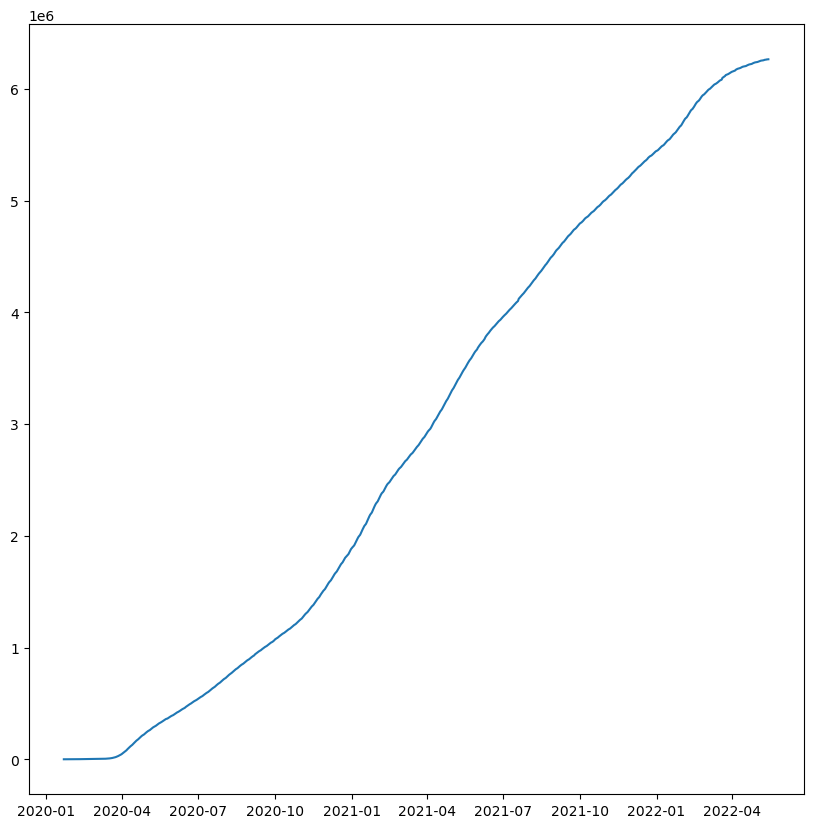

In [164]:
# plot th edaily number of deaths
plt.figure(figsize=(10,10))
plt.plot(dataset)
plt.savefig('cummulative_daily-deaths', bbox_inches='tight', transparent=False)

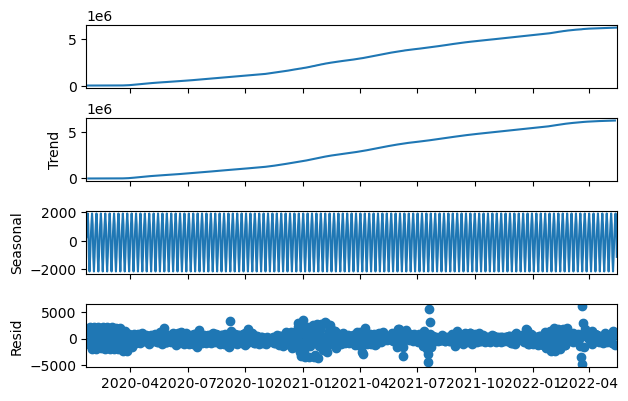

In [165]:
seas_d=sm.tsa.seasonal_decompose(dataset, model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

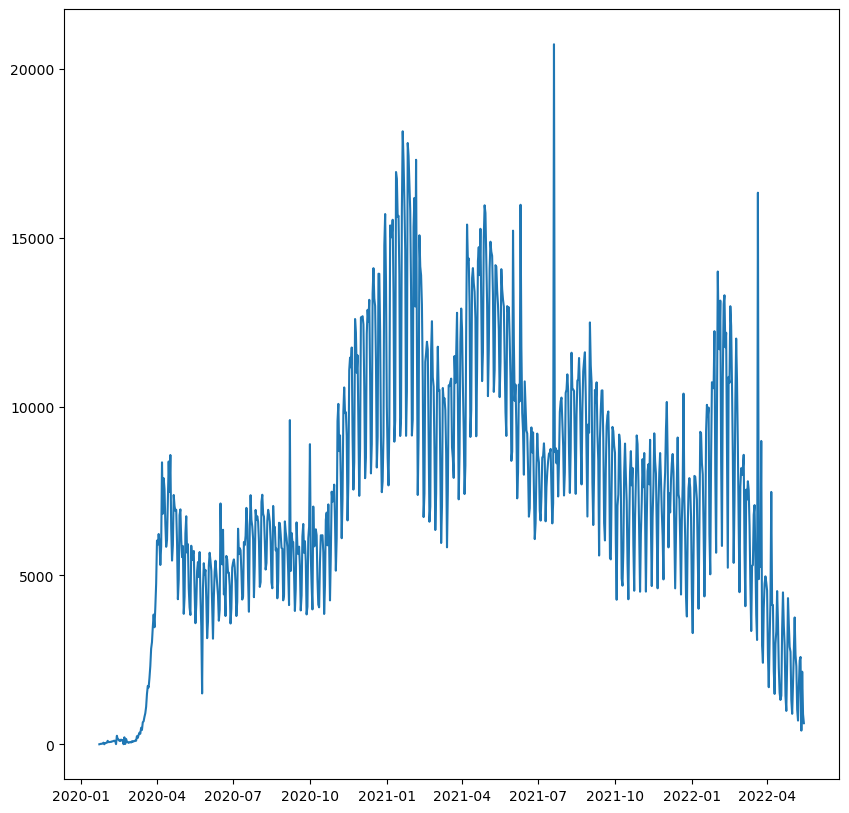

In [166]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff())
plt.savefig('daily_deaths_diff', bbox_inches='tight', transparent=False)


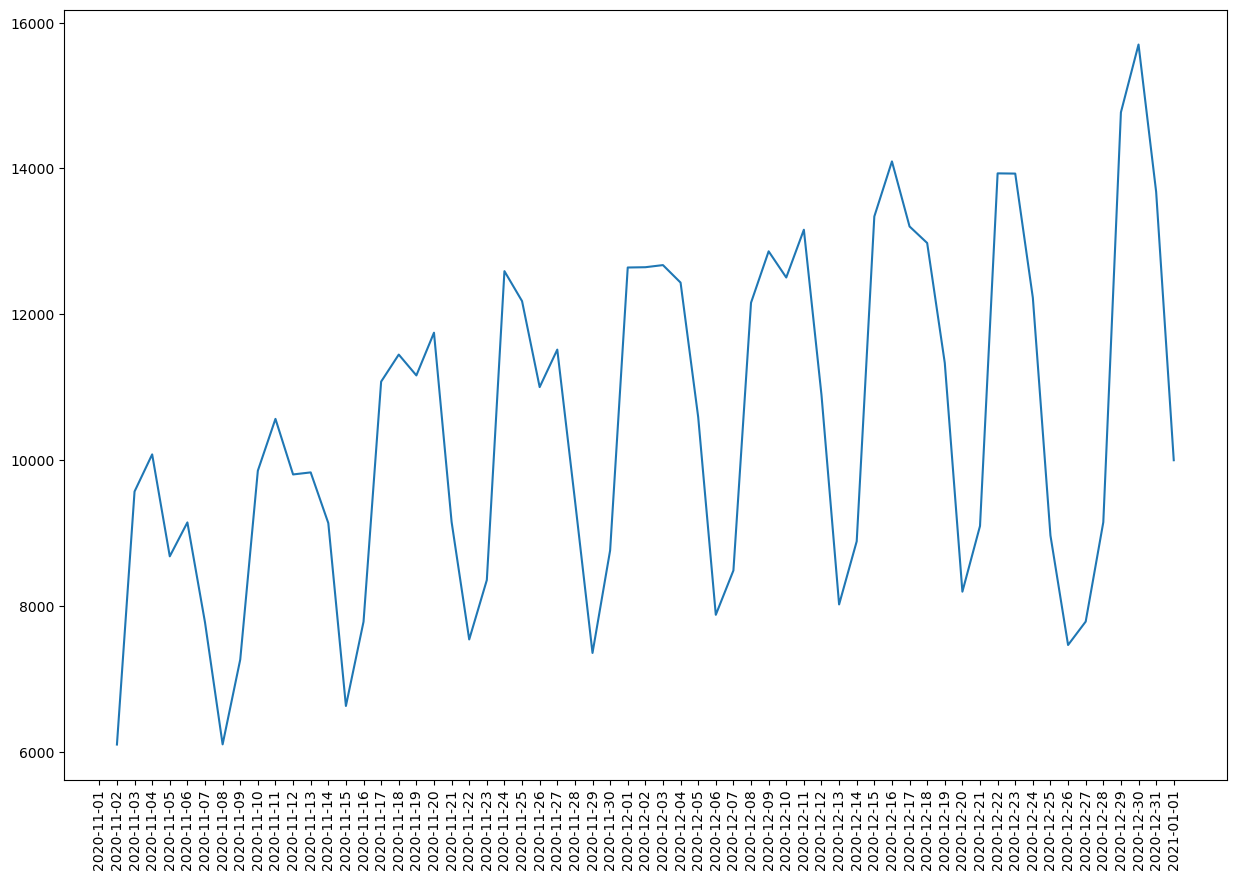

In [167]:
## zoom in
plt.figure(figsize=(15,10))
sample=dataset.loc['2020-11-01':'2021-01-01']
plt.plot(sample.diff())
plt.xticks(sample.index, rotation=90)
plt.savefig('daily_deaths_diff_sample', bbox_inches='tight', transparent=True)

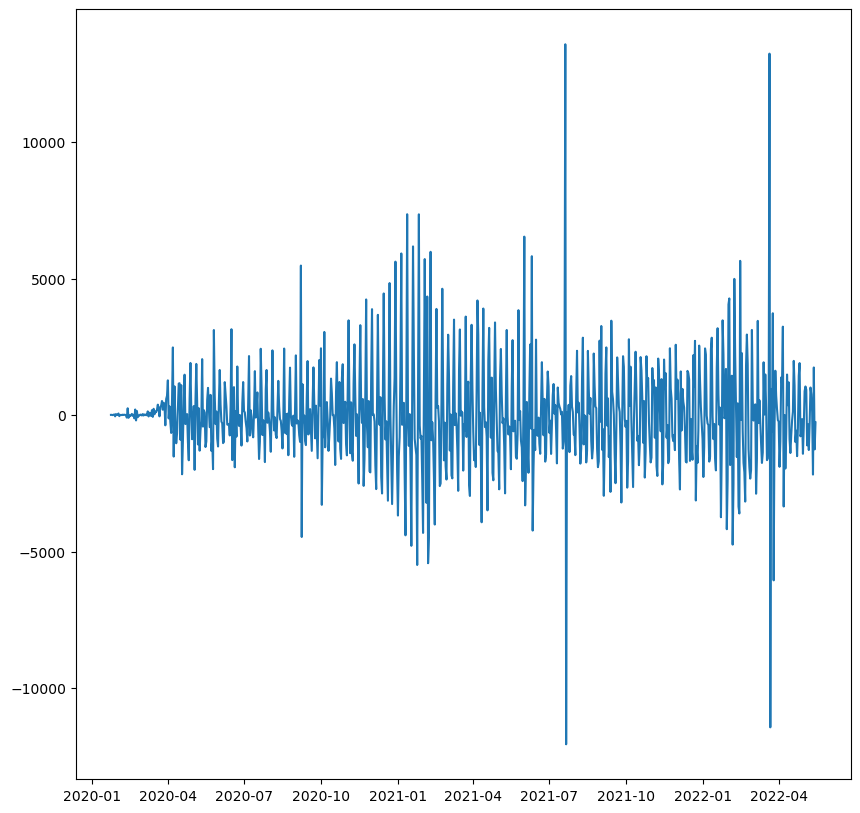

In [168]:
plt.figure(figsize=(10,10))
plt.plot(dataset.diff().diff())
plt.savefig('daily_deaths_2nd_order_diff', bbox_inches='tight', transparent=True)

This is clearly stationary enough, and we will be using this for our subsequent analysis.

The second-order differencing is essentially the difference of the difference, or the change in the change.

In [169]:
dataset_diff=dataset.diff().diff()

## we need to remove the first two data points, which will be two None b=values after applying diff() twice

dataset_diff=dataset_diff.loc['2020-01-24':]

2022-04-15


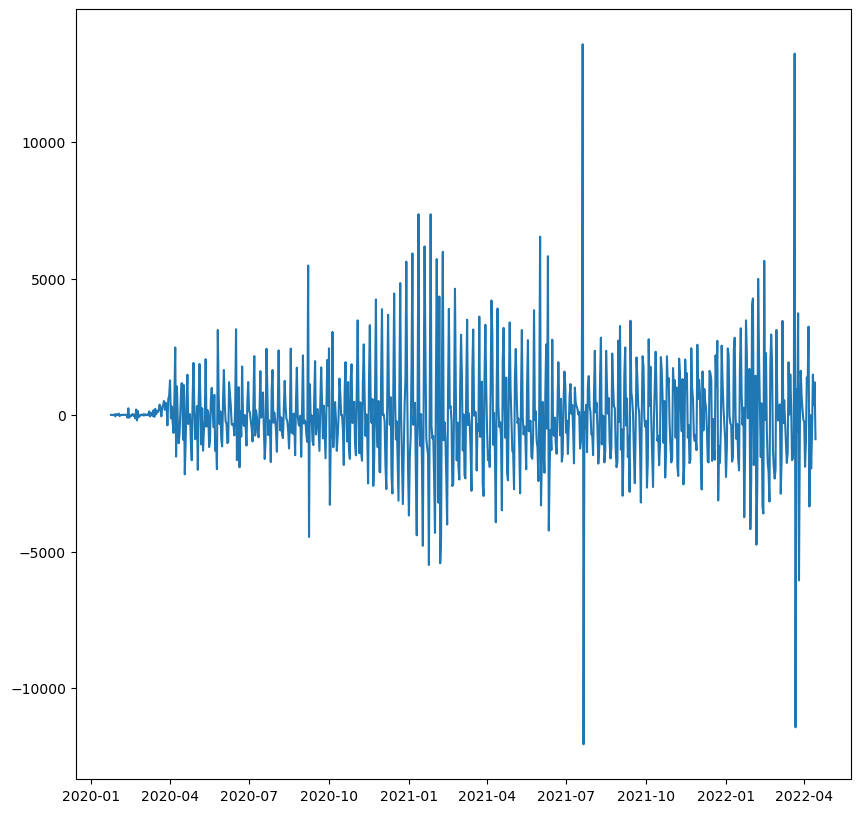

In [170]:
# split data into training set nad testing set

cutoff_date='2022-04-15'

print(cutoff_date)

train=dataset_diff.loc[dataset_diff.index<pd.to_datetime(cutoff_date)]
test=dataset_diff.loc[dataset_diff.index>=pd.to_datetime(cutoff_date)]

plt.figure(figsize=(10,10))
plt.plot(train)
plt.savefig('training_set', bbox_inches='tight', transparent=False)

## Forecasting using SARIMAX

In [171]:
model=SARIMAX(train, order=(2, 1, 3), seasonal_order=(0, 0,0,7))

In [172]:
results=model.fit(disp=True)

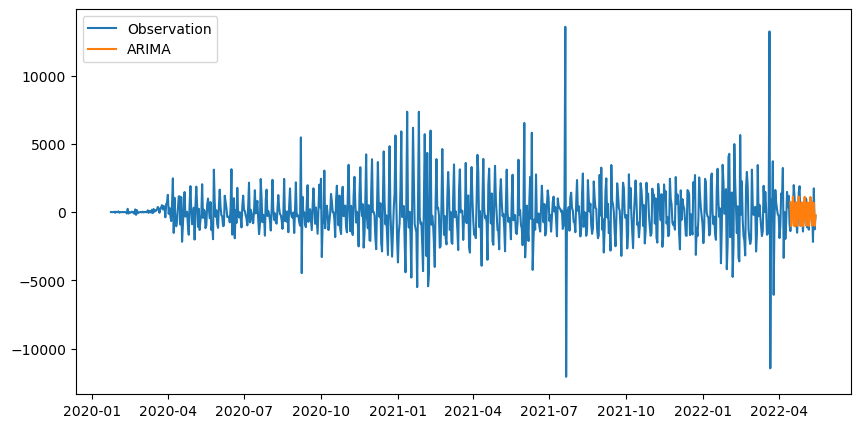

In [173]:
sarimax_prediction=results.predict(
    start=cutoff_date, end='2022-05-15', dynamic=False)

plt.figure(figsize=(10,5))
l1,=plt.plot(dataset_diff, label='Observation')
l2,=plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_prediction', bbox_inches='tight', transparent=False)

In [174]:
print('SARIMAX MAE= ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE=  973.1182274452372


In [175]:
model=pm.auto_arima(train, start_p=1, start_q=1,
                   m=7,
                   d=None,
                   seasonal=True,
                   start_P=0,
                   D=0,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=14177.689, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14608.306, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=14132.519, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14246.854, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14606.310, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=14609.181, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=14012.943, Time=1.30 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=13937.973, Time=1.41 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=13909.684, Time=0.93 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=14380.746, Time=0.32 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=13910.189, Time=1.42 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=14270.143, Time=0.55 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=14032.703, Time=0.67 sec
 ARIMA(2,0,0)(1,0,1)[7] i

In [176]:
if test.isnull().values.any():
    print("NaN values found in test dataset")
else:
    print("No NaN values in test dataset")

No NaN values in test dataset


In [177]:
sarimax_prediction_atutomated=model.predict(n_periods=test.shape[0])
sarimax_prediction_atutomated=pd.DataFrame({'ds': test.index,'y':sarimax_period_atutomated})
sarimax_prediction_atutomated.set_index('ds', inplace=True)
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset_diff, label='Observation')
l2,=plt.plot(sarimax_prediction, label='ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX_PREDICTION_AUTOMATED', bbox_inches='tight', transparent=False)
print('SARIMAX auto MAE= ', mean_absolute_error(sarimax_prediction_atutomated, test))

ValueError: Input contains NaN.

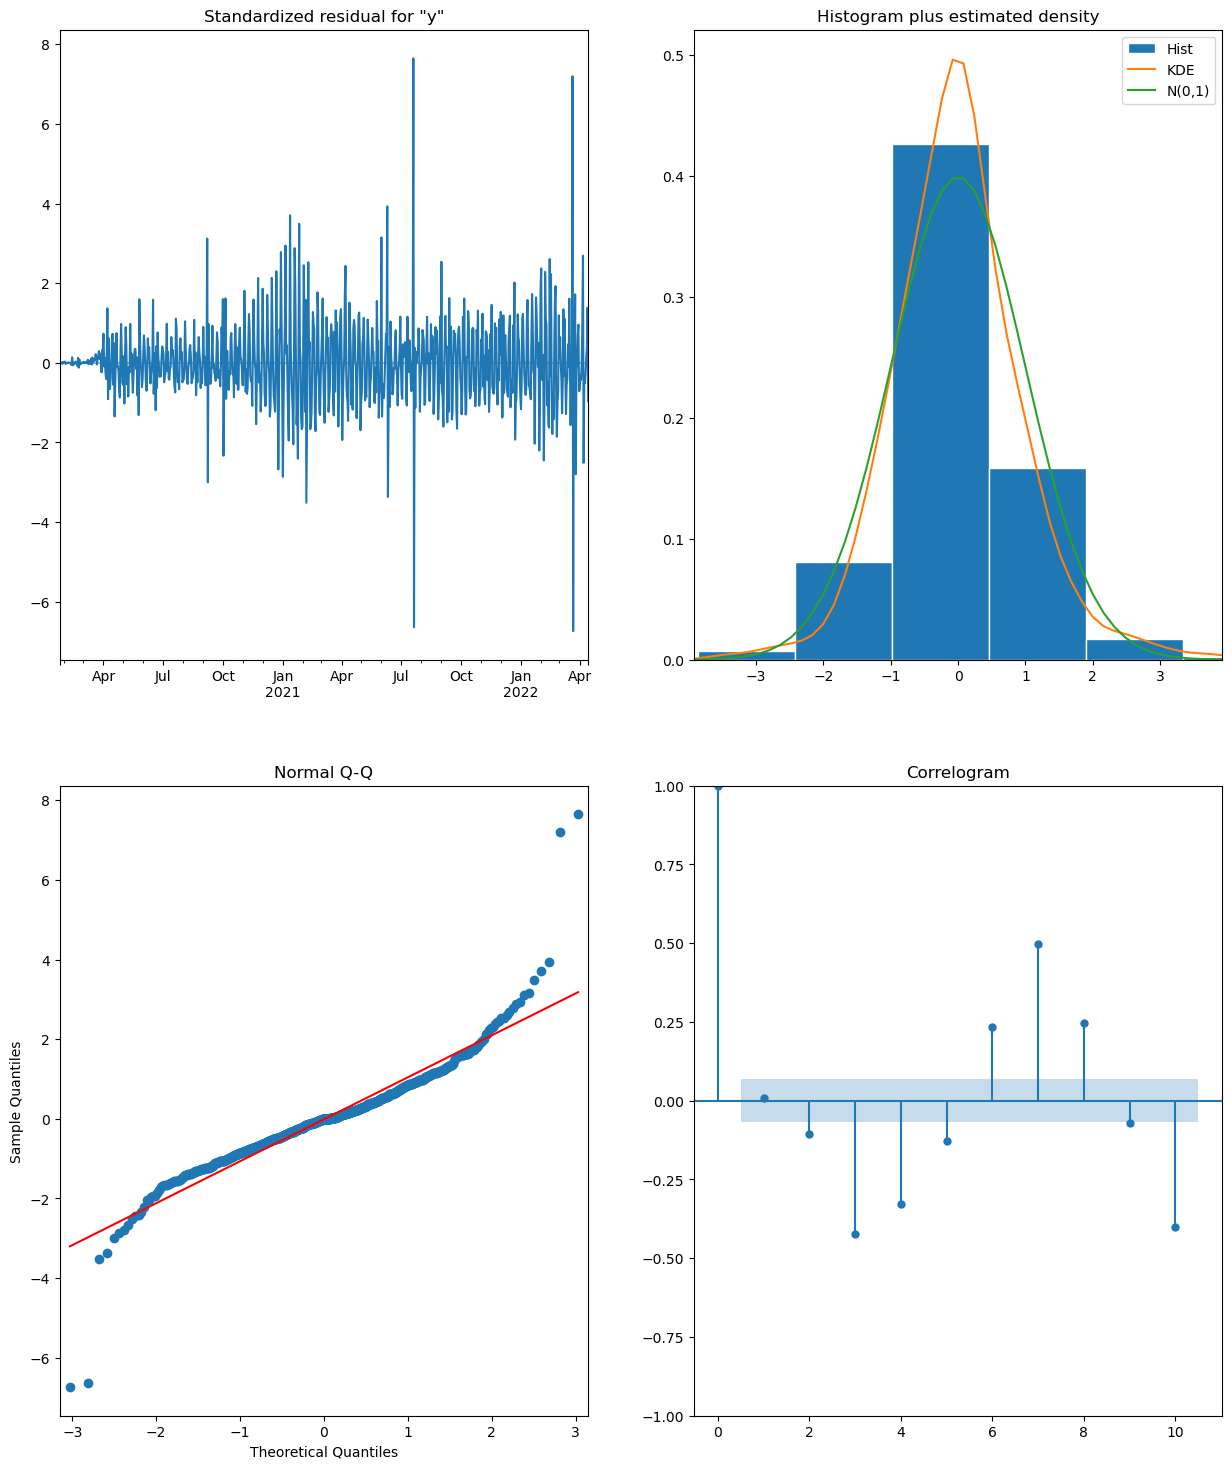

In [178]:
results.plot_diagnostics(figsize=(15, 18))
plt.show()

## Forecasting using facebook prophet model

In [179]:
train['ds']=train.index.values

In [180]:
m=Prophet()
m.fit(train)

17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] done processing


In [181]:
future=m.make_future_dataframe(periods=test.shape[0])
prophet_prediction=m.predict(future)

In [182]:
prophet_prediction=prophet_prediction.set_index('ds')
prophet_future=prophet_prediction.yhat.loc[prophet_prediction.index>=cutoff_date]
print('Prophet MAE= ', mean_absolute_error(prophet_future, test))

Prophet MAE=  703.8370577792017


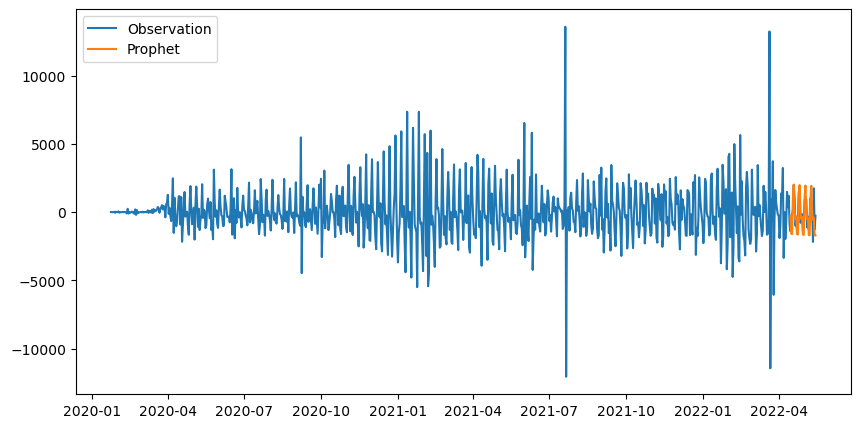

In [183]:
plt.figure(figsize=(10,5))
l1,=plt.plot(dataset_diff, label='Observation')
l2,=plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])
plt.savefig('prophet predictions',
                        bbox_inches='tight', transparent=False)

## Preparing the dataset for XGBoost and Neural Network

In [184]:
def featurize(t):
    X=pd.DataFrame()
    
    X['day']=t.index.day
    X['month']=t.index.month
    X['quarter']=t.index.quarter
    X['dayofweek']=t.index.dayofweek
    X['dayofyear']=t.index.dayofyear
    X['weekofyear']=t.index.weekofyear
    X['year']=t.index.year
    y=t.y
    return X,y

featurize(dataset_diff)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear,year
0,24,1,1,4,24,4,2020
1,25,1,1,5,25,4,2020
2,26,1,1,6,26,4,2020
3,27,1,1,0,27,5,2020
4,28,1,1,1,28,5,2020


## Splitting the dataset and data normalization

In [185]:
X_train, y_train=featurize(
                dataset_diff.loc[dataset_diff.index<pd.to_datetime(cutoff_date)])
X_test, y_test=featurize(
                dataset_diff.loc[dataset_diff.index>=pd.to_datetime(cutoff_date)])

In [186]:
# normalize the data

In [187]:
scaler=StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [188]:
scaled_train=scaler.transform(X_train)
scaled_test=scaler.transform(X_test)

## Train the XGBoost and Neural Network

In [189]:
XGBOOST_model= XGBRegressor(n_estimators=7)

In [190]:
XGBOOST_model.fit(scaled_train, y_train,
                 eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
                 verbose=True)

XGBOOST_prediction=XGBOOST_model.predict(scaled_test)

[0]	validation_0-rmse:1623.07002	validation_1-rmse:889.87923
[1]	validation_0-rmse:1375.19166	validation_1-rmse:842.74126
[2]	validation_0-rmse:1221.33542	validation_1-rmse:840.35634
[3]	validation_0-rmse:1127.12718	validation_1-rmse:844.59806
[4]	validation_0-rmse:1042.12564	validation_1-rmse:949.01447
[5]	validation_0-rmse:971.95283	validation_1-rmse:960.31329
[6]	validation_0-rmse:930.07191	validation_1-rmse:962.78586


In [191]:
print('XGBOOST MAE= ', mean_absolute_error(XGBOOST_prediction, y_test))

XGBOOST MAE=  790.2641170870874


### Creating and training of the feedforward neural network model

In [193]:
NN_model=Sequential()
NN_model.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NN_model.add(Dense(10))
NN_model.add(Dense(1))
NN_model.compile(loss='mean_absolute_error', optimizer=Adam(lr=0.001))
NN_model.fit(scaled_train, y_train, validation_data=(
            scaled_test, y_test), epochs=210, verbose=1)
NN_prediction=NN_model.predict(scaled_test)

Epoch 1/210
26/26 [==============================] - 1s 6ms/step - loss: 1293.3695 - val_loss: 935.2749
Epoch 2/210
26/26 [==============================] - 0s 2ms/step - loss: 1292.7855 - val_loss: 934.3457
Epoch 3/210
26/26 [==============================] - 0s 2ms/step - loss: 1292.1266 - val_loss: 933.1986
Epoch 4/210
26/26 [==============================] - 0s 2ms/step - loss: 1291.3307 - val_loss: 931.8694
Epoch 5/210
26/26 [==============================] - 0s 2ms/step - loss: 1290.3430 - val_loss: 930.2193
Epoch 6/210
26/26 [==============================] - 0s 2ms/step - loss: 1289.0791 - val_loss: 927.9874
Epoch 7/210
26/26 [==============================] - 0s 2ms/step - loss: 1287.4633 - val_loss: 925.2419
Epoch 8/210
26/26 [==============================] - 0s 2ms/step - loss: 1285.4645 - val_loss: 921.4947
Epoch 9/210
26/26 [==============================] - 0s 2ms/step - loss: 1282.8866 - val_loss: 917.2934
Epoch 10/210
26/26 [==============================] - 0s 2ms/ste

26/26 [==============================] - 0s 2ms/step - loss: 986.1784 - val_loss: 750.2068
Epoch 80/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8473 - val_loss: 750.4352
Epoch 81/210
26/26 [==============================] - 0s 2ms/step - loss: 985.9614 - val_loss: 751.1116
Epoch 82/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8549 - val_loss: 751.6794
Epoch 83/210
26/26 [==============================] - 0s 2ms/step - loss: 986.0896 - val_loss: 751.2345
Epoch 84/210
26/26 [==============================] - 0s 2ms/step - loss: 985.7870 - val_loss: 751.6641
Epoch 85/210
26/26 [==============================] - 0s 2ms/step - loss: 985.9480 - val_loss: 751.0621
Epoch 86/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8638 - val_loss: 751.4565
Epoch 87/210
26/26 [==============================] - 0s 2ms/step - loss: 985.9902 - val_loss: 752.3392
Epoch 88/210
26/26 [==============================] - 0s 2ms/step - loss: 985

26/26 [==============================] - 0s 2ms/step - loss: 985.6428 - val_loss: 749.2296
Epoch 158/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8040 - val_loss: 749.4850
Epoch 159/210
26/26 [==============================] - 0s 2ms/step - loss: 985.6925 - val_loss: 749.6522
Epoch 160/210
26/26 [==============================] - 0s 2ms/step - loss: 985.7545 - val_loss: 747.8845
Epoch 161/210
26/26 [==============================] - 0s 2ms/step - loss: 985.7713 - val_loss: 749.7305
Epoch 162/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8157 - val_loss: 748.4418
Epoch 163/210
26/26 [==============================] - 0s 2ms/step - loss: 985.7357 - val_loss: 749.3104
Epoch 164/210
26/26 [==============================] - 0s 2ms/step - loss: 985.6631 - val_loss: 749.4664
Epoch 165/210
26/26 [==============================] - 0s 2ms/step - loss: 985.8882 - val_loss: 748.5297
Epoch 166/210
26/26 [==============================] - 0s 2ms/step - 

In [194]:
print('XGBOOST MAE= ', mean_absolute_error(XGBOOST_prediction, y_test))
print('Prophet MAE= ', mean_absolute_error(prophet_future, test))
print('SARIMAX MAE= ', mean_absolute_error(sarimax_prediction, test))
print('NN MAE= ', mean_absolute_error(NN_prediction, test))

XGBOOST MAE=  790.2641170870874
Prophet MAE=  703.8370577792017
SARIMAX MAE=  973.1182274452372
NN MAE=  748.8681788290701


<Figure size 2000x2000 with 0 Axes>

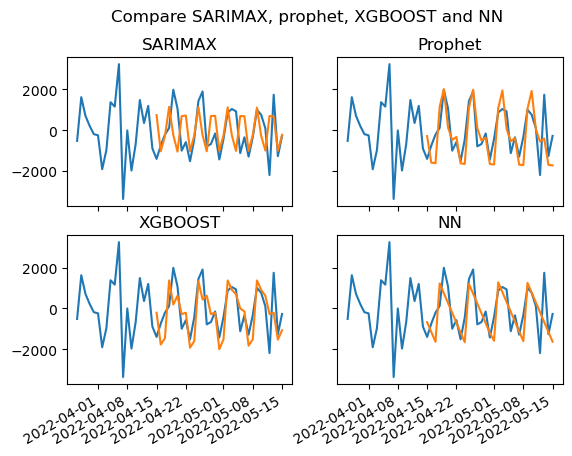

In [196]:
XGBOOST_df=pd.DataFrame({'y': XGBOOST_prediction.tolist()})
XGBOOST_df.index=y_test.index

NN_df=pd.DataFrame(NN_prediction)
NN_df.index=y_test.index
plt.figure(figsize=(20, 20))
fig, axs=plt.subplots(2, 2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0,0].plot(dataset_diff.tail(50))
axs[0,0].plot(sarimax_prediction.tail(50))
axs[0,0].set_title("SARIMAX")
axs[0,1].plot(dataset_diff.tail(50))
axs[0,1].plot(prophet_future.tail(50))
axs[0,1].set_title('Prophet')
axs[1,0].plot(dataset_diff.tail(50))
axs[1,0].plot(XGBOOST_df.tail(50))
axs[1,0].set_title("XGBOOST")
axs[1,1].plot(dataset_diff.tail(50))
axs[1,1].plot(NN_df.tail(50))
axs[1,1].set_title("NN")


for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()


plt.savefig('comparison',
           bbox_inches='tight', transparent=False)

### Forecast the future

In [197]:
sarimax_future_prediction=results.predict(start='2020-01-24', end='2022-06-15')
future=m.make_future_dataframe(periods=test.shape[0]+31) # 31 is number of days we want to predict in the future
prophet_future_prediction=m.predict(future)
prophet_future_prediction=prophet_future_prediction.set_index('ds')

In [199]:
def featurize_dates(t):
    X=pd.DataFrame()
    
    X['day']=t.index.day
    X['month']=t.index.month
    X['quarter']=t.index.quarter
    X['dayofweek']=t.index.dayofweek
    X['dayofyear']=t.index.dayofyear
    X['weekofyear']=t.index.weekofyear
    X['year']=t.index.year
    
    return X

In [200]:
future=future.set_index('ds')
X_future=featurize_dates(future)
scaled_future=scaler.transform(X_future)
XGBOOST_future=XGBOOST_model.predict(scaled_future)

In [202]:
NN_future=NN_model.predict(scaled_future)

28/28 [==============================] - 0s 738us/step


<Figure size 2000x2000 with 0 Axes>

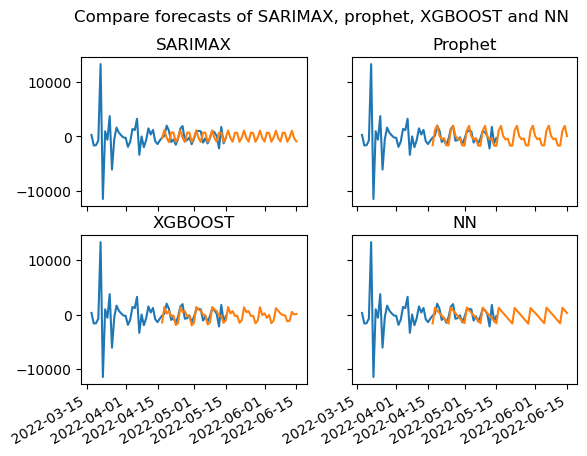

In [208]:
XGBOOST_df=pd.DataFrame({'y': XGBOOST_future.tolist()})
XGBOOST_df.index=future.index

future_prediction_count=31+test.shape[0]

NN_df=pd.DataFrame(NN_future)
NN_df.index=future.index

plt.figure(figsize=(20,20))
fig, axs=plt.subplots(2,2)

fig.suptitle('Compare forecasts of SARIMAX, prophet, XGBOOST and NN')
axs[0,0].plot(dataset_diff.tail(60))
axs[0,0].plot(sarimax_future_prediction.tail(60))
axs[0,0].set_title("SARIMAX")
axs[0,1].plot(dataset_diff.tail(60))
axs[0,1].plot(prophet_future_prediction['yhat'].tail(60))
axs[0,1].set_title("Prophet")
axs[1,0].plot(dataset_diff.tail(60))
axs[1,0].plot(XGBOOST_df.tail(60))
axs[1,0].set_title("XGBOOST")
axs[1,1].plot(dataset_diff.tail(60))
axs[1,1].plot(NN_df.tail(60))
axs[1,1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('comparison_forecasts',
           bbox_inches='tight', transparent=False)